<a href="https://colab.research.google.com/github/jpsiegel/Projects/blob/master/Tarea3_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Tarea 3 Jan P. Siegel - Deep Learning


##Allocate resources

In [ ]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil

import os
import GPUtil as GPU
import psutil
import humanize

In [2]:
def printm():
  GPUs = GPU.getGPUs()
  gpu = GPUs[0]  # Only one GPU on Colab and not guaranteed
  process = psutil.Process(os.getpid())
  print("RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " | Used: " + humanize.naturalsize(process.memory_info().rss))
  print("VRAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

RAM Free: 12.8 GB  | Used: 118.1 MB
VRAM Free: 16280MB | Used: 0MB | Util   0% Total 16280MB


In [3]:
from google.colab import drive
drive.mount('/content/drive')
my_dir = "/content/drive/MyDrive/DL"

Mounted at /content/drive


In [ ]:
# Download Roms
!wget http://www.atarimania.com/roms/Roms.rar > /dev/null
# Decompresed files
!unrar e Roms.rar > /dev/null
!unzip 'ROMS.zip' > /dev/null
# Add Roms folder to atary_py PATH
!python -m atari_py.import_roms 'ROMS' > /dev/null
# > /dev/null omits command output

##Preprocessing


In [5]:
import gym
from gym import spaces
import cv2

# pasar a escala de grises y recortar imagen
def _process_frame84(frame):
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    frame = frame[:155,10:]
    #x_t = cv2.resize(frame, (84, 84),  interpolation=cv2.INTER_LINEAR)
    x_t = cv2.resize(frame, (84, 84),interpolation=cv2.INTER_AREA)
    return x_t.astype(np.uint8)

class ProcessFrame84(gym.Wrapper):
    def __init__(self, env=None):
        super(ProcessFrame84, self).__init__(env)
        self.observation_space = spaces.Box(low=0, high=255, shape=(84, 84))

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        return _process_frame84(obs), reward, done, info

    def reset(self):
        return _process_frame84(self.env.reset())

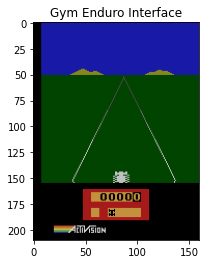

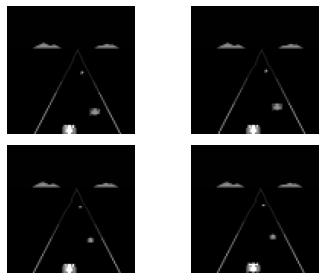

obs shape: (4, 84, 84)
actions: ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'DOWN', 'DOWNRIGHT', 'DOWNLEFT', 'RIGHTFIRE', 'LEFTFIRE'] amount: 9


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import random
from gym.wrappers import AtariPreprocessing
from gym.wrappers import FrameStack

#Create environment
game = 'Enduro-v0'
env = gym.make(game,frameskip=4) # saltamos de a 4 frames para acelerar entrenamiento

# For reproducibility
seed = 0
env.seed(seed)

obs = env.reset()

plt.imshow(np.squeeze(obs))
plt.title('Gym Enduro Interface')
plt.show()

env = ProcessFrame84(env) # pasamos el wrapper al enviroment
env = FrameStack(env,num_stack=4) # un estado definido como el actual mas los 3 anteriores
obs = env.reset()

for _ in range(100):
  action = random.randint(0,env.action_space.n-1) # seleccionar accion random
  obs, reward, done, info = env.step(action)

plt.figure()
plt.subplot(2,2,1)
plt.imshow(np.squeeze(np.array(obs)[0,:,:]),cmap='gray')
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(np.squeeze(np.array(obs)[1,:,:]),cmap='gray')
plt.axis('off')
plt.subplot(2,2,3)
plt.imshow(np.squeeze(np.array(obs)[2,:,:]),cmap='gray')
plt.axis('off')
plt.subplot(2,2,4)
plt.imshow(np.squeeze(np.array(obs)[3,:,:]),cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()

print("obs shape:", obs.shape)
print("actions:", env.get_action_meanings(), "amount:", env.action_space.n)

### Actividad 1
Definimos un estado como un stack de el frame actual, más los 3 frames anteriores, por lo que cada estado (que será el input de la red) corresponde a 4 pasos de Enduro. Esto es clave para que la red convolucional pueda tener una noción de velocidad del jugador y de los demás competidores. La velocidad solo puede obtenerse comparando posiciones en frames contiguas, lo cual es información indispensable para que un agente pueda aprender a jugar Enduro competentemente.

### Fill replay memory

In [7]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = [] # Can be a list a Deque or another type of list
        self.next_replace_position = 0

    def push(self, state, action, next_state, reward, done):
        """Saves a transition.
        e.g. ('state', 'action', 'next_state', 'reward','done')
        """
        memory_data = (state, action, next_state, reward, done)
        if len(self) >= self.capacity:
          self.memory[self.next_replace_position] = memory_data
          self.next_replace_position += 1
          if self.next_replace_position > self.capacity - 1:
            self.next_replace_position = 0
        else:
          self.memory.append(memory_data)

    def sample(self, batch_size):
       """ Samples a transition with a defined batch size"""
       sampled_tuples = random.sample(self.memory, batch_size) # list of tuples
       zipped = tuple(zip(*sampled_tuples))
       return zipped
      
    def __len__(self):
        return len(self.memory)

In [8]:
memory_size = 500000
replay_memory = ReplayMemory(memory_size)
loaded_model = False

print("Filling random Replay Memory...")
current_obs = env.reset()
for _ in range(memory_size):
  if _ % 100000 == 0:
    print(f"{_}/{memory_size}")
  action = random.randint(0, env.action_space.n-1) # seleccionar accion random
  obs, reward, done, info = env.step(action)
  replay_memory.push(current_obs, action, obs, reward, done)
  current_obs = obs
  if done: # si pierde partimos nuevo episodio
    current_obs = env.reset()

print("Random Replay Memory Filled!, Resources:")
printm()

Filling random Replay Memory...
0/500000
100000/500000
200000/500000
300000/500000
400000/500000
Random Replay Memory Filled!, Resources:
RAM Free: 8.3 GB  | Used: 4.6 GB
VRAM Free: 16280MB | Used: 0MB | Util   0% Total 16280MB


##Model

### Actividad 2
Implementación en Pytorch de Dueling DQN

In [9]:
import torch
import torch.nn as nn
import numpy as np

class Dueling_DQN(nn.Module):
    def __init__(self, in_channels, num_actions):
        super(Dueling_DQN, self).__init__()
        self.num_actions = num_actions
        
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1)

        self.fc1_val = nn.Linear(in_features=7*7*64, out_features=512)
        self.fc2_val = nn.Linear(in_features=512, out_features=1)

        self.fc1_adv = nn.Linear(in_features=7*7*64, out_features=512)
        self.fc2_adv = nn.Linear(in_features=512, out_features=num_actions)

        self.relu = nn.ReLU()

    def forward(self, x):
      # X es un tensor (batch_size x 4 x 84 x 84) que representa un batch de stacks de estados
      batch_size = x.size(0)

      # forward pass red convolucional
      x = self.relu(self.conv1(x))
      x = self.relu(self.conv2(x))
      x = self.relu(self.conv3(x))
      x = torch.flatten(x, start_dim=1) # start_dim 1 para mantener separado el batch
      #print("State embedding:", x.shape, x)
      
      # forward pass rama fully-connected para V(s)
      v_s = self.relu(self.fc1_val(x))
      v_s = self.fc2_val(v_s).expand(batch_size, self.num_actions)
      #print("V(s):", v_s.shape, v_s)

      # forward pass rama fully-connected para A(s,a)
      adv = self.relu(self.fc1_adv(x))
      adv = self.fc2_adv(adv)
      #print("A(s,a):", adv.shape, adv)
      #print("mean A(s,a):", torch.mean(adv, 1, keepdim=True).shape, torch.mean(adv, 1, keepdim=True))

      # Calculo de Q(s,a) a partir de ecuacion (4)
      Q_values = v_s + (adv - torch.mean(adv, 1, keepdim=True)) # testeado

      return Q_values # batch_size x num_actions

##Training

In [10]:
def exploration(total_steps):
  """ retorna probabilidad de que explore con accion random """
  if total_steps >= 1000000:
    epsilon = 0.1
  else:
    m = -0.9 / 1000000
    n = 1
    epsilon = m * total_steps + n
  return epsilon

In [11]:
# Define parameters and instance NNs

from torch import device
import torch.optim as optim
import torch.nn as nn

device = device('cuda' if torch.cuda.is_available() else 'cpu')

frame_history_len = 4 # Cantidad de frames de cada estado (definido en el pre-procesamiento)
batch_size = 32
gamma = 0.99 # Factor de descuento
learning_starts = 50000 # Paso en que se comienza a utilizar la red para escoger acciones (siguiendo política e-greedy)
learning_freq = 4 # Frecuencia de pasos en que se modifican los pesos (loss backprop) en la red Q
target_update_freq = 10000 # Frecuencia en que se actualizan los pesos de la red target Q' (cada x backprops, updateo Q')
LR = 0.00025 # learning rate

in_channels = frame_history_len
input_shape = (84,84)
num_actions = env.action_space.n

# define Q target and Q 
Q = Dueling_DQN(in_channels, num_actions).to(device) # esta es la que de verdad quiero entrenar
Q_target = Dueling_DQN(in_channels, num_actions).to(device) # para estabilidad, esta me entrega los labels

# Optimizador, pueden elegir entre Adam o RMSProp
optimizer = optim.Adam(Q.parameters(), lr=LR)

LOG_EVERY_N_STEPS = 50000 # (Opcional) Frecuencia en la que se muestran resultados en consola
STEPS_PER_EPOCH = 100000 # Pasos por época
N_EPOCHS = 50 # Número de épocas

In [ ]:
# Run only if continuing training of existing model

import torch
import numpy as np

# load state dict and pass it to Q and Q_target
model_save_path = my_dir + "/DQN_model_X.pt"
Q.load_state_dict(torch.load(model_save_path, map_location=device))
Q_target.load_state_dict(torch.load(model_save_path, map_location=device))
optimizer = optim.Adam(Q.parameters(), lr=LR)
loaded_model = True

memory_size = 500000
replay_memory = ReplayMemory(memory_size)

print("Filling Replay Memory with pretrained DQN...")
current_obs = env.reset()
for _ in range(memory_size):
  if _ % 100000 == 0:
    print(f"{_}/{memory_size}")
    with torch.no_grad(): # no actualizamos gradientes pq estamos evaluando
      # Seleccionar la acción segun la red Q
      last_obs_tensor = torch.from_numpy(np.array(current_obs)).to(device) / 255.0 # pasamos a tensor y normalizamos
      last_obs_tensor_batched = last_obs_tensor.unsqueeze(0).repeat(batch_size, 1, 1, 1) # last obs solo es 1 estado, pero necesitamos batch_size estados para la red
      all_q_values = Q(last_obs_tensor_batched)
      action = ((all_q_values).data.max(1)[1])[0].item() # selecciono indice de mejor q_value
  obs, reward, done, info = env.step(action)
  replay_memory.push(current_obs, action, obs, reward, done)
  current_obs = obs
  if done: # si pierde partimos nuevo episodio
    current_obs = env.reset()

print("Pretrained Replay Memory Filled!, Resources:")
printm()

In [12]:
from tqdm import tqdm
import torch
import numpy as np
import json

if not loaded_model:
  reward_history = {0: 0.0} # epoch: mean reward of last 100 episodes
  error_history = {0: 0.0} # epoch: mean error
else:
  a_file = open(my_dir + "/rewards.json", "r")
  reward_history = json.loads(a_file.read())
  a_file.close()

  b_file = open(my_dir + "/errors.json", "r")
  error_history = json.loads(b_file.read())
  b_file.close()

last_obs = env.reset() # Reseteamos nuestro ambiente para empezar el entrenamiento
current_reward = 0
backprops = 0
episodes_rewards = [0]
errors = [0]

for epoch in tqdm(range(N_EPOCHS),position=0,leave=True):
  for t in tqdm(range(STEPS_PER_EPOCH),position=0,leave=True):
    total_steps = t + STEPS_PER_EPOCH * epoch # steps acumulados a traves de las epocas
    ### 1. Choose actions and update replay memory buffer
    if t < learning_starts and epoch == 0:
      action = np.random.randint(num_actions)
    else:
      # epsilon greedy exploration
      sample = random.random()
      threshold = exploration(total_steps)  # la funcion exploration permite calcular el threshold para la política e-greedy
      if sample <= threshold:
        action = np.random.randint(num_actions)
      else:
        with torch.no_grad(): # no actualizamos gradientes pq estamos evaluando
          # Seleccionar la acción segun la red Q
          last_obs_tensor = torch.from_numpy(np.array(last_obs)).to(device) / 255.0 # pasamos a tensor y normalizamos
          last_obs_tensor_batched = last_obs_tensor.unsqueeze(0).repeat(batch_size, 1, 1, 1) # last obs solo es 1 estado, pero necesitamos batch_size estados para la red
          all_q_values = Q(last_obs_tensor_batched)
          action = ((all_q_values).data.max(1)[1])[0].item() # selecciono indice de mejor q_value

    obs, reward, done, _ = env.step(action) # ejecuto accion seleccionada
    replay_memory.push(last_obs, action, obs, reward, done) # actualizo experiencia en buffer
    current_reward += reward
    if done:
      # Termino episodio!
      obs = env.reset()
      # Guardar reward acumulado del episodio
      episodes_rewards.append(current_reward)
      current_reward = 0

    # update last_obs
    last_obs = obs

    ### 2. Perform experience replay and train the network.
    if (t > learning_starts and t % learning_freq == 0):
      obs_t, act_t, next_obs, rew_t, done_mask = replay_memory.sample(batch_size) # esto me deja listas de largo batch size
      # Pasar los arreglos a tensores y al device actual
      obs_t = torch.from_numpy(np.array(obs_t)).to(device)
      act_t = torch.from_numpy(np.array(act_t)).to(device)
      next_obs = torch.from_numpy(np.array(next_obs)).to(device)
      rew_t = torch.from_numpy(np.array(rew_t)).to(device)
      done_mask = torch.from_numpy(np.array(done_mask)).to(device)

      # Normalizar tensores de entrada
      obs_t = obs_t / 255.0
      next_obs = next_obs / 255.0

      # construir Y (labels)
      with torch.no_grad(): # esto no debe ser parte del backprop, solo consigue los labels
        q_tp1_values = Q(next_obs)
        _, a_prime = q_tp1_values.max(1) # selecciono la mejor accion para el estado siguiente
        q_target_tp1_values = Q_target(next_obs)
        q_target_s_a_prime = q_target_tp1_values.gather(1, a_prime.unsqueeze(1)).squeeze() # selecciono el q_value de la target network segun la mejor accion en el estado siguiente
        # si termina en este episodio, los q_values de target son 0 y dejamos solo el reward
        q_target_s_a_prime = (1 - done_mask.type(torch.float)) * q_target_s_a_prime 
        
        y = rew_t + gamma * q_target_s_a_prime

      ## Loss calculation
      q_values = Q(obs_t)
      q_s_a = q_values.gather(1, act_t.unsqueeze(1)).squeeze() # selecciono el q de cada accion
      error = (y - q_s_a) ** 2
      error = torch.mean(error.clamp(0, 1)) # clipeamos para estabilidad
      errors.append(error.item())

      # backwards pass
      optimizer.zero_grad()
      error.backward()

      # update
      optimizer.step()
      backprops += 1

      # Actualizar pesos de red target (cada target_update_freq actualizaciones de los parámetros de Q')
      if backprops % target_update_freq == 0:
        #print("Copying model weights...")
        Q_target.load_state_dict(Q.state_dict()) # copiamos pesos de Q a Qtarget

  mean_reward = np.mean(episodes_rewards[-100:]) if len(episodes_rewards) > 100 else sum(episodes_rewards) / len(episodes_rewards)
  mean_error = np.mean(errors[-100:]) if len(errors) > 100 else sum(errors) / len(errors)
  
  # Epoch ends
  print("\nEpoch:", epoch + 1)

  # Save model and results
  model_save_path = my_dir + "/DQN_model_{}.pt".format(epoch + 1)
  torch.save(Q.state_dict(), model_save_path)

  reward_history[epoch + 1] = mean_reward
  error_history[epoch + 1] = mean_error

  a_file = open(my_dir + "/rewards.json", "w")
  json.dump(reward_history, a_file)
  a_file.close()

  b_file = open(my_dir + "/errors.json", "w")
  json.dump(error_history, b_file)
  b_file.close()

  episodes_rewards = [] # reset
  errors = [] # reset
  print("Model and data saved!")

  0%|          | 81/100000 [00:00<02:03, 808.87it/s]


Epoch: 1
Model and data saved!


  0%|          | 79/100000 [00:00<02:07, 783.07it/s]


Epoch: 2
Model and data saved!


  0%|          | 69/100000 [00:00<02:25, 688.17it/s]


Epoch: 3
Model and data saved!


100%|██████████| 100000/100000 [04:12<00:00, 395.62it/s]



Epoch: 4


  0%|          | 71/100000 [00:00<02:23, 698.54it/s]

Model and data saved!


  0%|          | 62/100000 [00:00<02:41, 617.09it/s]


Epoch: 5
Model and data saved!


  0%|          | 64/100000 [00:00<02:36, 637.49it/s]


Epoch: 6
Model and data saved!


  0%|          | 60/100000 [00:00<02:47, 595.32it/s]


Epoch: 7
Model and data saved!


  0%|          | 59/100000 [00:00<02:52, 578.13it/s]


Epoch: 8
Model and data saved!


  0%|          | 50/100000 [00:00<03:20, 499.32it/s]


Epoch: 9
Model and data saved!


  0%|          | 50/100000 [00:00<03:22, 493.30it/s]


Epoch: 10
Model and data saved!


  0%|          | 52/100000 [00:00<03:14, 513.74it/s]


Epoch: 11
Model and data saved!


  0%|          | 50/100000 [00:00<03:23, 491.96it/s]


Epoch: 12
Model and data saved!


  0%|          | 54/100000 [00:00<03:07, 532.97it/s]


Epoch: 13
Model and data saved!


 28%|██▊       | 14/50 [1:04:31<3:00:43, 301.21s/it]


Epoch: 14
Model and data saved!


  0%|          | 50/100000 [00:00<03:22, 494.20it/s]


Epoch: 15
Model and data saved!


  0%|          | 51/100000 [00:00<03:17, 506.47it/s]


Epoch: 16
Model and data saved!


  0%|          | 51/100000 [00:00<03:17, 506.03it/s]


Epoch: 17
Model and data saved!


  0%|          | 54/100000 [00:00<03:06, 535.32it/s]


Epoch: 18
Model and data saved!


  0%|          | 52/100000 [00:00<03:13, 517.54it/s]


Epoch: 19
Model and data saved!


  0%|          | 48/100000 [00:00<03:29, 476.13it/s]


Epoch: 20
Model and data saved!


  0%|          | 49/100000 [00:00<03:26, 484.26it/s]


Epoch: 21
Model and data saved!


  0%|          | 50/100000 [00:00<03:22, 492.78it/s]


Epoch: 22
Model and data saved!


  0%|          | 50/100000 [00:00<03:21, 494.84it/s]


Epoch: 23
Model and data saved!


  0%|          | 50/100000 [00:00<03:20, 498.39it/s]


Epoch: 24
Model and data saved!


  0%|          | 48/100000 [00:00<03:30, 475.35it/s]


Epoch: 25
Model and data saved!


  0%|          | 0/100000 [00:00<?, ?it/s]


Epoch: 26
Model and data saved!


  0%|          | 52/100000 [00:00<03:12, 519.18it/s]


Epoch: 27
Model and data saved!


  0%|          | 53/100000 [00:00<03:09, 528.68it/s]


Epoch: 28
Model and data saved!


  0%|          | 53/100000 [00:00<03:09, 526.18it/s]


Epoch: 29
Model and data saved!


  0%|          | 49/100000 [00:00<03:25, 485.48it/s]


Epoch: 30
Model and data saved!


  0%|          | 51/100000 [00:00<03:16, 509.63it/s]


Epoch: 31
Model and data saved!


  0%|          | 48/100000 [00:00<03:29, 477.79it/s]


Epoch: 32
Model and data saved!


  0%|          | 52/100000 [00:00<03:13, 515.44it/s]


Epoch: 33
Model and data saved!


  0%|          | 50/100000 [00:00<03:23, 490.40it/s]


Epoch: 34
Model and data saved!


  0%|          | 51/100000 [00:00<03:19, 500.59it/s]


Epoch: 35
Model and data saved!


  0%|          | 52/100000 [00:00<03:13, 517.83it/s]


Epoch: 36
Model and data saved!


  0%|          | 0/100000 [00:00<?, ?it/s]


Epoch: 37
Model and data saved!


  0%|          | 49/100000 [00:00<03:25, 487.35it/s]


Epoch: 38
Model and data saved!


  0%|          | 49/100000 [00:00<03:24, 488.61it/s]


Epoch: 39
Model and data saved!


  0%|          | 51/100000 [00:00<03:17, 507.30it/s]


Epoch: 40
Model and data saved!


  0%|          | 52/100000 [00:00<03:16, 509.47it/s]


Epoch: 41
Model and data saved!


  0%|          | 48/100000 [00:00<03:31, 472.28it/s]


Epoch: 42
Model and data saved!


  0%|          | 51/100000 [00:00<03:19, 501.96it/s]


Epoch: 43
Model and data saved!


  0%|          | 51/100000 [00:00<03:16, 508.05it/s]


Epoch: 44
Model and data saved!


  0%|          | 51/100000 [00:00<03:18, 504.08it/s]


Epoch: 45
Model and data saved!


  0%|          | 50/100000 [00:00<03:22, 493.82it/s]


Epoch: 46
Model and data saved!


  0%|          | 51/100000 [00:00<03:19, 500.54it/s]


Epoch: 47
Model and data saved!


100%|██████████| 100000/100000 [05:08<00:00, 324.50it/s]



Epoch: 48


  0%|          | 49/100000 [00:00<03:25, 486.98it/s]

Model and data saved!


  0%|          | 49/100000 [00:00<03:25, 486.28it/s]


Epoch: 49
Model and data saved!


100%|██████████| 50/50 [4:09:30<00:00, 299.42s/it]


Epoch: 50
Model and data saved!


### Actividad 3
La diferencia entre DQN y Dueling DQN (DDQN) [2], radica en la arquitectura usada para calcular los valores Q(s,a) (la bonificacion de ejecutar acción *a* estando en estado *s*). DQN usa un *backbone* convolucional seguido de unas capas *fully connected* para producir los *Q-values*, mientras que DDQN obtiene dos *streams* a partir de las capas convolucionales. En uno se calcula V(s) (valor intrínseco de estar en estado *s*) y en el otro se calcula A(s,a), es decir la ventaja de ejecutar la acción *a* por sobre otra acción estando en el estado *s*.
Como indica el paper, de forma intuitiva, la red debe entonces aprender cuál es es valor de un estado *s*, sin tener que aprender el efecto de cada acción sobre ese estado. Esto es muy provechoso en entornos donde gran parte del tiempo las acciones no afectan el entorno, como es el caso de Enduro. Buena parte del juego solo se debe manejar manteniéndose en la pista, y solo podemos afectar el entorno cuando tenemos otros autos cercanos al nuestro, lo que ocurre con menos frecuencia.




### Actividad 4

La ventaja de usar un buffer o Replay Memory, es para obtener mejores minibatches. En ausencia de un buffer de memoria, tenemos que hacer que el modelo juege algunas iteraciones (ej 32) para poder llenar un batch y hacer el forward pass por la red. Sin embargo, en este caso los 32 datos estarían muy correlacionados, puesto que vienen de una jugada contigua, lo que es un gran sesgo para el entrenamiento, ya que no es una muestra representativa de todos los estados posibles del entorno. Aquí entra la ventaja del buffer, de donde podemos recurrir a experiencias de jugadas anteriores y llenar un batch sampleando aleatoriamente de dicho buffer, logrando capturar la diversidad de estados para así tener una muestra representativa del problema para ajustar los pesos de la red.

Por su parte, se usa un algoritmo ϵ-greedy dinámico, en el sentido que la probabilidad de tomar una accíon al azar comienza muy alta (100%) y va bajando linearmente a lo largo del entrenamiento hasta llegar a un 10%. 
Esto es para incorporar el concepto de explotación vs exploración dentro del 
entrenamiento: un agente que lleva poco actuando en el entorno, conoce pocas 
acciones realmente buenas, por lo que le conviene explorar nuevas opciones al azar para descubrir posibilidades inexploradas. Sin embargo, después de un tiempo el agente ya conoce mejor el entorno y cómo operar sobre él, por lo que conviene que ejecute sus mejores decisiones previas para explotar su conocimiento obtenido sobre el entorno. De esta forma hacemos que paulatinamente se pase de explorar el entorno, a explotar el conocimiento obtenido sobre el entorno.

Es por esto que el buffer de memoria tendrá cada vez menos jugadas aleatorias, y cada vez más jugadas estimadas por la red. Esto actualiza la fuente de donde sampleamos nuestro batches de entrenamiento, por lo que lentamente comenzaremos a entrenar sobre la experiencia obtenida anteriormente.


In [61]:
import torch.nn as nn
import torch.nn.functional as F

class standard_DQN(nn.Module):
    def __init__(self, in_channels, num_actions):
        super(standard_DQN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc4 = nn.Linear(7*7*64, 512)
        self.fc5 = nn.Linear(512, num_actions)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc4(x.view(x.size(0), -1)))
        return self.fc5(x)

DQN = standard_DQN(4,9)
DDQN = Dueling_DQN(4, 9)

#No. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The standard DQN model has {count_parameters(DQN):,} trainable parameters')
print(f'The Dueling DQN model has {count_parameters(DDQN):,} trainable parameters')

The standard DQN model has 1,688,745 trainable parameters
The Dueling DQN model has 3,295,402 trainable parameters


###Actividad 5
Mediante esta función para contar los parámetros de un modelo, podemos observar que *Dueling DQN* usa casi el doble de los parámetros de una red normal. Lo cual tiene mucho sentido, puesto que la versión Dueling usa el mismo *backbone* convolucional, pero duplica las capas *fully connected* para poder tener una rama que calcule el valor del estado V(s) y otra que calcule el valor de la ventaja A(s,a). Siendo las *fully connected* las capas con mayor cantidad de parámetros, al duplicar la cantidad de estas capas, es de esperar que la cantidad de parámetros totales esté cercano al doble de una DQN standard.

### Actividad 6

Se implementó una red Q-target para agregar estabilidad a la red, y una política e-greedy que desciende linealmente y un Replay Memory Buffer eficiente usando numpy y zip, el cual aumentó significativamente las it/s del entrenamiento. Además, para sortear problemas de memoria, la implementación guarda una copia de los parámetros del modelo. En caso de terminarse el runtime por cualquier eventualidad, dicha copia puede cargarse, usarse para rellenar el memory buffer con sus predicicones, y continuar el entrenamiento. El reward también se guarda en formato json para poder retomar las estadísticas del entrenamiento.

Pasando a los hiperparámetros, se usan todos basándose en el paper [1]:

- minibatch size = 32
- replay memory size = 500.000 (mitad para conservar memoria)
- agent history len = 4 
- batch_size = 32
- target network update freq = 10000
- discount factor = 0.99 (gamma)
- action repeat = 4 ( parametro frame skip)
- update frequency = 4 (acciones antes de un backpropagation)
- learning rate = 0.00025
- initial exploration = 1 (100%)
- final exploration = 0.1 (10%)
- final exploration frame = 1000000
- replay start size = 50000

Solo se cambió:
1. El replay memory size a la mitad para conservar memoria
2. El optimizador en Adam, ya que mostró mejores resultados y it/s algo más rápidas
3. La estructura de las épocas (50 epocas de 100.000 pasos) para obtener un gráfico más suave  
4. No se usa momentum

## Results

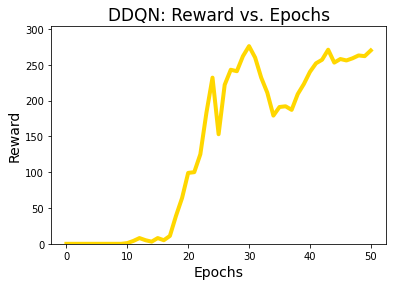

In [56]:
import json
import matplotlib.pyplot as plt
import numpy as np

# open saved reward history
a_file = open(my_dir + "/rewards.json", "r")
reward_history = json.loads(a_file.read())
a_file.close()

# sort for epochs and unpack
reward_history_values = [int(n[1]) for n in sorted(reward_history.items(), key=lambda x: int(x[0]))]

# plot 
plt.title("DDQN: Reward vs. Epochs", fontdict={"fontsize": 17})
plt.xlabel("Epochs", fontdict={"size": 14})
plt.ylabel("Reward", fontdict={"size": 14})
plt.plot(range(0, N_EPOCHS+1), reward_history_values, label="Reward", color="gold", linewidth=4)
plt.ylim((0, max(reward_history_values) * 1.1))
plt.xticks(np.arange(0, N_EPOCHS+1, 10))
plt.show()

###Actividad 7
En este gráfico podemos ver el progreso del entrenamiento, donde se mide el puntaje promedio obtenido en cada época. Este se calcula con los últimos 100 episodios de cada época, para obtener más datapoints consideré una epoca como 100.000 pasos y el entrenamiento duró 50 épocas.
Observamos que inicialmente el *reward* se mantiene cercano a 0, porque todavía ocupa en su mayor parte pasos aleatorios dado por ϵ-greedy y cada episodio termina muy rápido. Luego, alrededor de la época 20 comienza a notarse su entrenamiento: hace más pasos propios por la politica ϵ-greedy y además el replay buffer contiene experiencias mejores que las inciales.
También podemos notar la alta variabilidad de los modelos de aprendizaje reforzado profundo. A pesar de clippear el error y usar una red independiente para calcular los labels, alrededor de la época 25 y 35 vemos repentinos saltos en el *reward* obtenido.

###Testing visualization

In [74]:
import torch
import numpy as np

# load state dict and pass it to Q and Q_target
model_save_path = my_dir + "/DQN_model_50.pt"
Q.load_state_dict(torch.load(model_save_path, map_location=device))
Q_target.load_state_dict(torch.load(model_save_path, map_location=device))
optimizer = optim.Adam(Q.parameters(), lr=LR)


print("Playing Enduro with trained DDQN...")
current_obs = env.reset()
frames = []
rewards = []
current_reward = 0
for _ in range(5000):
  with torch.no_grad(): # no actualizamos gradientes pq estamos evaluando
    # Seleccionar la acción segun la red Q
    last_obs_tensor = torch.from_numpy(np.array(current_obs)).to(device) / 255.0 # pasamos a tensor y normalizamos
    last_obs_tensor_batched = last_obs_tensor.unsqueeze(0).repeat(batch_size, 1, 1, 1) # last obs solo es 1 estado, pero necesitamos batch_size estados para la red
    all_q_values = Q(last_obs_tensor_batched)
    action = ((all_q_values).data.max(1)[1])[0].item() # selecciono indice de mejor q_value
  obs, reward, done, info = env.step(action)
  current_reward += reward
  frames.append(obs[0])
  current_obs = obs
  if done: # si pierde partimos nuevo episodio
    current_obs = env.reset()
    current_reward = 0
  rewards.append(current_reward)
max_index = rewards.index(max(rewards))

streak_idx = 0
total_streak = 0
current_streak = 0
current_idx = 0
first_it = True
for r in rewards:
  if not first_it:
    if r > rewards[current_idx - 1]:
      current_streak += 1
    else:
      current_streak = 0
  if current_streak > total_streak:
    total_streak = current_streak
    streak_idx = current_idx
  first_it = False
  current_idx += 1
print("Max reward obtained: {}".format(max(rewards)))


Playing Enduro with trained DDQN...
Max reward obtained: 270.0


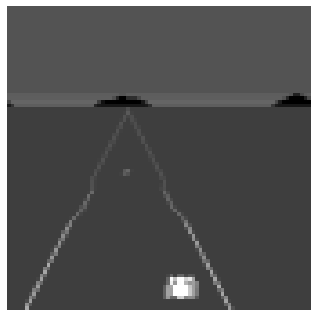

In [90]:
import matplotlib.pyplot as plt
import matplotlib.animation
from IPython.display import HTML

show_length = 100
frames_show = frames[max_index-show_length:max_index + 20]

plt.figure(figsize=(frames_show[0].shape[1] / 15.0, frames_show[0].shape[0] / 15.0), dpi = 72)
patch = plt.imshow(frames_show[0],cmap='gray')
plt.axis('off')
animate = lambda i: patch.set_data(frames_show[i])
ani = matplotlib.animation.FuncAnimation(plt.gcf(), animate, frames=len(frames_show), interval = 100)
HTML(ani.to_jshtml())

Vemos que el agente aprende a acelerar y esquivar oponentes!
Le falta precisión para poder pasar entre dos autos eso sí parece

##Referencias

1. *Mnih, V., Kavukcuoglu, K., Silver, D., Rusu, A. A., Veness, J., Bellemare, M. G., ...  Hassabis, D. (2015). Human-level control through Deep Reinforcement Learning. Nature, 518(7540), 529-533.*
2. *Wang, Z., Schaul, T., Hessel, M., Hasselt, H., Lanctot, M.,   Freitas, N. (2016, June). Dueling Network Architectures for Deep Reinforcement Learning. In International conference on Machine Learning (pp. 1995-2003). PMLR.*

Forward pass and training algorithm adapted from
3. *Pytorch implementation of Human-level control through deep reinforcement learning by @transedward.         
Available at: https://github.com/transedward/pytorch-dqn*
4. *PyTorch implementation of Vanilla DQN, Double DQN, and Dueling DQN by @dxyang.         
 Available at: https://github.com/dxyang/DQN_pytorch*